In [1]:
library(glmmSeq)
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



In [2]:
load('h5ad/df.fil3_gex_bcells_vdj_sce_B_nonswitched_mem_deg_270622.RData')
ls()

[1] "res1"     "results1"

In [3]:
library(dplyr)
makeGeneList <- function(gl, beta_column='beta'){
    y <- grepl('^RPS|^RPL|^MT-', row.names(gl))
    gl <- gl[!y, ]
    rank <- -log10(gl$pval) * sign(gl[,beta_column])
    rank[which(rank == Inf)] <- 300
    rank[which(rank == -Inf)] <- 300
    names(rank) <- row.names(gl)
    rank <- rev(sort(rank))
    gl <- rank
    return(gl)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
head(results1)
dim(results1)

,beta,pval,qval,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCRL5,0.7936127,0.002389844,0.06687217,0,0
S100A11,0.7512869,0.003596534,0.08100097,0,0
CTSC,0.6427186,0.001790110,0.06150009,0,0
FABP5,0.5558313,0.006777715,0.10577289,0,0
ARPC1B,0.4991182,0.004843938,0.08998067,0,0
FGR,0.4950851,0.062335555,0.30417443,0,0


[1] 196   5

In [5]:
# head(results2)
# dim(results2)

In [6]:
# head(results3)
# dim(results3)

In [7]:
library(fgsea)
library(msigdbr)

In [8]:
h <- data.frame(msigdbr::msigdbr(category = "H", species = 'Homo sapiens'))
h <- split(h, h$gs_name)
h <- lapply(h, function(x) x %>% dplyr::select(gene_symbol) %>% unlist %>% as.character)

In [9]:
plotGSEA_Hallmark <- function(gsea, fdr_cutoff = 0.25, cols = NULL, xlim = NULL, newlabels = NULL, keep_significant_only = TRUE, jitter = FALSE) {
    require(ggplot2)
    gsea$NES[which(is.na(gsea$NES))] <- 0
    gsea$pval[which(is.na(gsea$pval))] <- 1
    gsea$padj[which(is.na(gsea$padj))] <- 1
    gsea$ranking[which(is.na(gsea$ranking))] <- 0
    gsea <- gsea[order(gsea$ranking),]
    
    if (keep_significant_only){
        gseax <- split(gsea, gsea$pathway)
        for (i in 1:length(gseax)){
            if (all(gseax[[i]]$pval >= 0.05)|all(gseax[[i]]$padj >=fdr_cutoff)){
                gseax[[i]] <- NA        
            }
        }
        gseax <- gseax[!is.na(gseax)]
        gsea <- do.call(rbind, gseax)        
    }
    if (!is.null(gsea)){
        gsea <- gsea[order(gsea$ranking), ]
        gsea$pathway <- gsub("HALLMARK_|", "", gsea$pathway)

        if (!is.null(xlim)){
            x_lim_min = -xlim
            x_lim_max = xlim
        } else {
            x_lim_min <- abs(ceiling(min(-log10(gsea$padj))))
            x_lim_max <- abs(ceiling(max(-log10(gsea$padj))))
        }
        
        if(x_lim_min > x_lim_max){
            xval1 <- x_lim_min * -1
            xval2 <- x_lim_min
        } else {
            xval1 <- x_lim_max * -1
            xval2 <- x_lim_max
        }

        if(!is.null(cols)){
            gg_color_hue <- function(n) {
                hues = seq(15, 375, length = n + 1)
                hcl(h = hues, l = 65, c = 100)[1:n]
            }
            cols. = gg_color_hue(dplyr::n_distinct(gsea$group, na.rm = TRUE))
        } else {
            cols. = cols
        }    
    
        g <- ggplot(gsea, aes(x = -log10(padj)*sign(NES), y = reorder(pathway, ranking), col = -log10(padj)*sign(NES), size = abs(NES)))
        if (jitter){
            g <- g + geom_point(position = 'jitter')
        }else{
            g <- g + geom_point()
        }
        g <- g + theme_bw() +
            labs(x = expression(paste("Signed", " -log" ["10"], "adjusted pval")), y = "Hallmarks") +
            geom_vline(xintercept = 0) +
            geom_vline(xintercept = -log10(fdr_cutoff)) +
            geom_vline(xintercept = -log10(fdr_cutoff)*-1) +
            scale_x_continuous(limits = c(xval1, xval2), oob = scales::squish) +
            scale_size_area(oob = scales::squish, max_size = 3, limits = c(0,2)) +
            theme(panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(), 
                panel.background = element_blank(), 
                axis.line = element_blank(), 
                axis.ticks = element_blank(),
                axis.text = element_text(color = 'black'),
                axis.title = element_text(color = 'black'))
        
        return(g)
    }
}

Loading required package: ggplot2



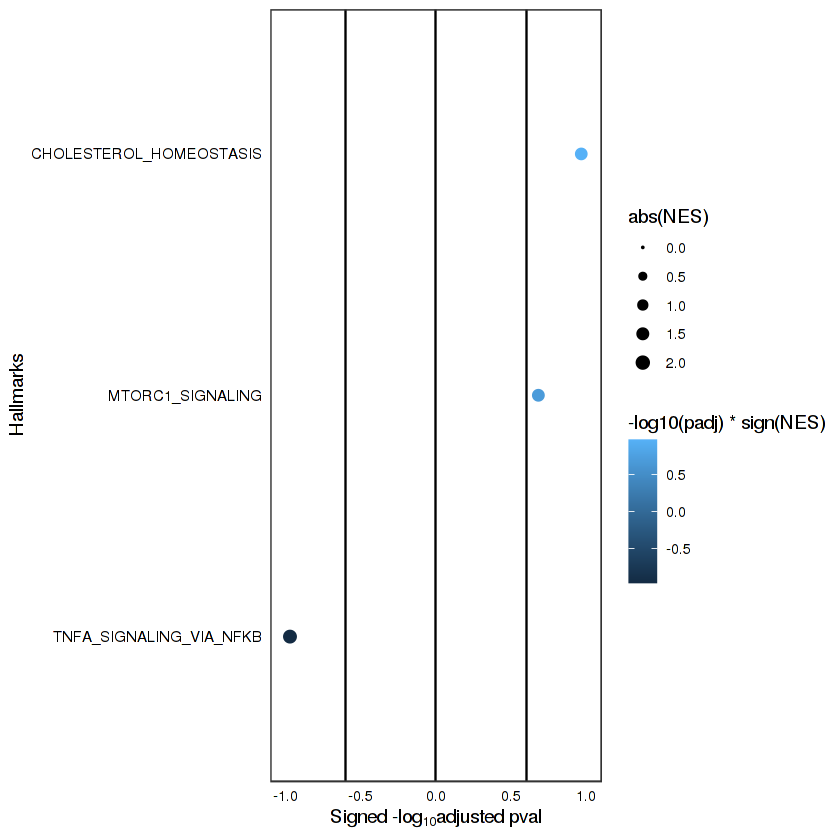

In [10]:
gl1 <- makeGeneList(results1)
res1gsea <- fgsea(pathways = h, stats = gl1, minSize = 0, maxSize =1000)
res1gsea$ranking <- -log10(res1gsea$pval) * sign(res1gsea$NES)
plotGSEA_Hallmark(res1gsea)

In [11]:
# gl2 <- makeGeneList(results2)
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

In [12]:
# gl3 <- makeGeneList(results3)
# res3gsea <- fgsea(pathways = h, stats = gl3, minSize = 0, maxSize =1000)
# res3gsea$ranking <- -log10(res3gsea$pval) * sign(res3gsea$NES)
# plotGSEA_Hallmark(res3gsea)